## **Text Processing**

In [1]:
import pandas as pd

combined_canonical = pd.read_csv("/content/combined_canonical_v1.csv")

/tmp/ipython-input-2722424305.py:3: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_canonical = pd.read_csv("/content/combined_canonical_v1.csv")


In [2]:
combined_canonical.info()
combined_canonical.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129334 entries, 0 to 129333
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   job_id            129334 non-null  int64  
 1   job_title         129334 non-null  object 
 2   company           129334 non-null  object 
 3   location          129334 non-null  object 
 4   experience_level  99932 non-null   object 
 5   job_description   129334 non-null  object 
 6   salary_final      11772 non-null   float64
 7   industry          5491 non-null    object 
 8   sub_industry      5491 non-null    object 
 9   source            129334 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 9.9+ MB


,0
job_id,0
job_title,0
company,0
location,0
experience_level,29402
job_description,0
salary_final,117562
industry,123843
sub_industry,123843
source,0


### Text Cleaning

Transformed job_description into clean_description by:

- Converting text to lowercase

- Removing HTML tags

- Removing punctuation, numbers, and special characters

- Normalizing whitespace

- Safely handling missing values (NaN → "")

In [3]:
import re

def clean_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r"<.*?>", " ", text)
    text = re.sub(r"[^a-zA-Z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

combined_canonical["clean_description"] = combined_canonical["job_description"].apply(clean_text)


In [4]:
combined_canonical["clean_description"].head()
combined_canonical["clean_description"].str.len().describe()


,clean_description
count,129334.000000
mean,3660.648484
std,2145.967257
min,2.000000
25%,2095.000000
50%,3326.000000
75%,4836.750000
max,31522.000000


### Stopword Removal

Removed high-frequency, low-information words using NLTK which include:

- the, and, is, for, with, to, of

**Why this is necessary**

These words:

- Appear in almost every document

- Carry no skill, role, or domain information

- Inflate feature space later

Removing them:

- Improves signal-to-noise ratio

- Makes skills like python, sql, aws stand out

- Improves clustering and modeling quality later

In [5]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))

def remove_stopwords(text):
    return " ".join(w for w in text.split() if w not in stop_words)

combined_canonical["clean_description"] = combined_canonical["clean_description"].apply(remove_stopwords)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Verification

This includes:

- Before and after clean description check
- Length Reduction Check
- Stopword Effect Check
- Null Safety Check


In [6]:
combined_canonical[
    ["job_description", "clean_description"]
].sample(5, random_state=42)


,job_description,clean_description
35000,Description\n\nCompany: Oak Street Health\n\nT...,description company oak street health title me...
35370,"LOCATION: Watertown / New York (US-NY), United...",location watertown new york us ny united state...
328,The Terra Forza Golf team is growing! Territor...,terra forza golf team growing territory determ...
63701,The ideal candidate is a skilled professional ...,ideal candidate skilled professional passionat...
21765,Position Summary...\n\nAs a Bakery Department ...,position summary bakery department lead drive ...


In [7]:
"the" in combined_canonical["clean_description"].iloc[0].split()


False

In [8]:
combined_canonical["job_description"].str.len().describe()
combined_canonical["clean_description"].str.len().describe()


,clean_description
count,129334.000000
mean,2980.924792
std,1731.072435
min,2.000000
25%,1721.000000
50%,2739.000000
75%,3935.000000
max,25010.000000


In [9]:
combined_canonical["clean_description"].isnull().sum()


np.int64(0)

### Inspect Most Common Tokens

In [10]:
from collections import Counter

all_words = " ".join(combined_canonical["clean_description"]).split()
common_words = Counter(all_words).most_common(30)
common_words


[('experience', 398816),
 ('work', 371327),
 ('team', 260841),
 ('skills', 205574),
 ('job', 192258),
 ('including', 189339),
 ('ability', 180643),
 ('business', 179234),
 ('management', 176906),
 ('required', 175554),
 ('time', 172546),
 ('company', 164643),
 ('position', 160449),
 ('customer', 151481),
 ('support', 150492),
 ('benefits', 141826),
 ('service', 135044),
 ('years', 133483),
 ('care', 133077),
 ('information', 132343),
 ('health', 125345),
 ('sales', 124034),
 ('requirements', 121252),
 ('must', 118153),
 ('services', 117519),
 ('may', 117206),
 ('opportunity', 117012),
 ('data', 116101),
 ('development', 115662),
 ('status', 114136)]

### Noise Word Set

In [11]:
noise_words = {
    "experience", "years", "year", "ability", "skills", "knowledge",
    "role", "responsibilities", "responsible", "work", "working",
    "team", "teams", "looking", "candidate", "position", "job",
    "required", "preferred", "strong", "excellent", "good", "including",
    "time", "company", "benefits", "requirements", "must", "may", "opportunity"
}


### Noise Removal

In [12]:
def remove_noise_words(text):
    return " ".join(
        word for word in text.split()
        if word not in noise_words
    )

combined_canonical["clean_description"] = (
    combined_canonical["clean_description"]
    .apply(remove_noise_words)
)


### After Removal Check

In [13]:
from collections import Counter

Counter(
    " ".join(combined_canonical["clean_description"]).split()
).most_common(20)


[('business', 179234),
 ('management', 176906),
 ('customer', 151481),
 ('support', 150492),
 ('service', 135044),
 ('care', 133077),
 ('information', 132343),
 ('health', 125345),
 ('sales', 124034),
 ('services', 117519),
 ('data', 116101),
 ('development', 115662),
 ('status', 114136),
 ('new', 112181),
 ('environment', 110247),
 ('employment', 109014),
 ('provide', 107242),
 ('related', 103396),
 ('customers', 101993),
 ('medical', 98617)]

### Update the Dataset

In [14]:
combined_canonical.to_csv(
    "/content/combined_canonical_v2.csv",
    index=False
)


In [15]:
combined_canonical.columns


Index(['job_id', 'job_title', 'company', 'location', 'experience_level',
       'job_description', 'salary_final', 'industry', 'sub_industry', 'source',
       'clean_description'],
      dtype='object')

### Import Required Tools

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer


## Configure TF-IDF

In [17]:
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.8
)


## Fit & transform

In [18]:
X_tfidf = tfidf.fit_transform(
    combined_canonical["clean_description"]
)


## Sanity checks

In [19]:
X_tfidf.shape


(129334, 5000)

### Vocabulary inspection

In [20]:
tfidf.get_feature_names_out()[:20]


array(['aa', 'abilities', 'abilities include', 'able', 'able communicate',
       'able lift', 'able perform', 'able read', 'abreast', 'absence',
       'abuse', 'academic', 'academy', 'accelerate', 'accept',
       'acceptable', 'acceptance', 'accepted', 'accepting', 'access'],
      dtype=object)

### Non-zero density check

In [21]:
X_tfidf.nnz / (X_tfidf.shape[0] * X_tfidf.shape[1])


0.0456680316080845

## Persist artifacts

In [22]:
import joblib

joblib.dump(tfidf, "tfidf_vectorizer_v1.pkl")
joblib.dump(X_tfidf, "X_tfidf_v1.pkl")


['X_tfidf_v1.pkl']

## Build a skill vocabulary

In [23]:
SKILL_VOCAB = {
    "python", "java", "sql", "excel", "power bi", "tableau",
    "machine learning", "deep learning", "nlp",
    "tensorflow", "pytorch",
    "aws", "azure", "gcp",
    "docker", "kubernetes",
    "react", "node", "fastapi", "django",
    "git", "linux"
}


### Extract skills from each job

In [24]:
def extract_skills(text, skill_vocab):
    found = set()
    text = text.lower()
    for skill in skill_vocab:
        if skill in text:
            found.add(skill)
    return list(found)

combined_canonical["extracted_skills"] = combined_canonical[
    "clean_description"
].apply(lambda x: extract_skills(x, SKILL_VOCAB))


### Verify and Do Sanity Check

In [25]:
combined_canonical[["job_title", "extracted_skills"]].tail(50)


,job_title,extracted_skills
129284,Experienced Travel Agent,[excel]
129285,Travel Agent,[]
129286,Reservation Specialist / Customer Service Agent,[]
129287,Reservation Specialist Vacation Rentals,[]
129288,Reservation Specialist,[]
129289,Reservation Specialist/Part Time,[excel]
129290,Reservation Specialist,[]
129291,Reservation Specialist,[]
129292,Travel Advisor - Corporate & Leisure,[]
129293,Luxury Travel Sales Agent,[]


In [26]:
combined_canonical[
    combined_canonical["extracted_skills"].str.len() > 0
][["job_title", "extracted_skills"]].head(20)


,job_title,extracted_skills
1,Mental Health Therapist/Counselor,[excel]
3,Senior Elder Law / Trusts and Estates Associat...,[excel]
8,Respiratory Therapist,"[react, excel]"
10,Inside Customer Service Associate,[excel]
11,Project Architect,"[git, excel]"
12,Appalachian Highlands Women's Business Center,[excel]
14,Senior Product Marketing Manager,[git]
16,Administrative Coordinator,[aws]
18,"Content Writer, Communications",[excel]
19,Controller,[excel]


### Creating Skill Dictionaries

In [27]:
technical_skills = {
    "python", "java", "c++", "javascript", "sql", "excel",
    "aws", "azure", "gcp",
    "docker", "kubernetes",
    "git", "linux",
    "tensorflow", "pytorch",
    "power bi", "tableau"
}


In [28]:
domain_skills = {
    "data analysis", "data science", "machine learning",
    "web development", "backend", "frontend",
    "cloud computing", "devops",
    "cybersecurity", "networking"
}


In [29]:
business_tools = {
    "excel", "word", "powerpoint",
    "crm", "sap", "salesforce",
    "jira", "confluence"
}


### Re-Run Extraction

In [30]:
def extract_skills(text, skill_vocab):
    text = text.lower()
    return sorted([
        skill for skill in skill_vocab
        if skill in text
    ])


#### Added Missing Column

In [31]:
combined_canonical["job_text"] = (
    combined_canonical["job_title"].fillna("") + " " +
    combined_canonical["clean_description"].fillna("")
)


### Coverage Check

In [32]:
combined_canonical["skills_v2"] = combined_canonical["job_text"].apply(
    lambda x: extract_skills(x, SKILL_VOCAB)
)

coverage = (
    combined_canonical["skills_v2"].str.len() > 0
).mean()

coverage


np.float64(0.534631264787295)

### Sanity Check

In [33]:
combined_canonical[
    combined_canonical["skills_v2"].str.len() > 0
][["job_title", "skills_v2"]].sample(20)


,job_title,skills_v2
128044,Government Information Specialist,[aws]
118074,Capital Projects Engineer,"[aws, excel]"
114543,Customer Service Representative,[excel]
12559,Clinical Informatics Specialist,[excel]
122241,Trainer,[excel]
30573,HP Nonstop Software Engineer,"[linux, python]"
36574,Store Manager,"[aws, excel]"
34672,Document Control Specialist,[git]
65394,Machine Learning Engineer,"[linux, machine learning, python, sql]"
36516,SENIOR BUYER,[excel]


## Creating Normalized Skill Column

In [34]:
# Skill normalization map (v1)
skill_map = {
    "amazon web services": "aws",
    "aws cloud": "aws",
    "reactjs": "react",
    "nodejs": "node",
    "javascript": "javascript",
    "js": "javascript",
    "python3": "python",
    "k8s": "kubernetes",
    "postgres": "postgresql",
    "postgre": "postgresql",
}

def normalize_skills(skill_list):
    if not isinstance(skill_list, list):
        return []
    normalized = []
    for s in skill_list:
        s = s.lower().strip()
        normalized.append(skill_map.get(s, s))
    return list(set(normalized))  # remove duplicates

combined_canonical["skills_norm"] = combined_canonical["skills_v2"].apply(normalize_skills)


### Verify Normalization

In [35]:
combined_canonical[["skills_v2", "skills_norm"]].sample(10)


,skills_v2,skills_norm
28493,[excel],[excel]
51490,"[aws, azure, docker, kubernetes]","[azure, docker, aws, kubernetes]"
17458,[],[]
74661,[],[]
48933,"[excel, java, node, react, sql]","[java, excel, sql, node, react]"
18226,[],[]
117681,[],[]
75436,[],[]
8618,[excel],[excel]
543,[],[]


### Skill frequency table

In [36]:
from collections import Counter

all_skills = combined_canonical["skills_norm"].explode()
skill_counts = Counter(all_skills.dropna())

skill_freq_df = (
    pd.DataFrame(skill_counts.items(), columns=["skill", "count"])
      .sort_values("count", ascending=False)
)

skill_freq_df.head(20)


,skill,count
0,excel,40025
3,aws,23233
2,git,14815
4,sql,6322
8,python,5274
5,java,4345
1,react,3298
10,azure,3087
12,linux,1957
13,machine learning,1897


### Sanity checks

In [37]:
skill_freq_df.tail(20)


,skill,count
2,git,14815
4,sql,6322
8,python,5274
5,java,4345
1,react,3298
10,azure,3087
12,linux,1957
13,machine learning,1897
6,tableau,1388
16,kubernetes,1316


In [38]:
skill_freq_df.describe()


,count
count,22.000000
mean,5123.090909
std,9530.486126
min,35.000000
25%,468.500000
50%,1352.000000
75%,4083.250000
max,40025.000000


In [39]:
skill_freq_df[skill_freq_df["count"] > 10000]


,skill,count
0,excel,40025
3,aws,23233
2,git,14815


### Save artifacts

In [40]:
skill_freq_df.to_csv("skill_frequency_v1.csv", index=False)
combined_canonical.to_csv("combined_with_skills_norm_v1.csv", index=False)


In [41]:
skill_freq_df["percentage"] = (
    skill_freq_df["count"] / skill_freq_df["count"].sum()
).round(4)


## Creating Views For Skills

### Top Skills by Frequency (Absolute Demand)

In [42]:
top_n = 20

top_skills = skill_freq_df.sort_values("count", ascending=False).head(top_n)

top_skills


,skill,count,percentage
0,excel,40025,0.3551
3,aws,23233,0.2061
2,git,14815,0.1314
4,sql,6322,0.0561
8,python,5274,0.0468
5,java,4345,0.0386
1,react,3298,0.0293
10,azure,3087,0.0274
12,linux,1957,0.0174
13,machine learning,1897,0.0168


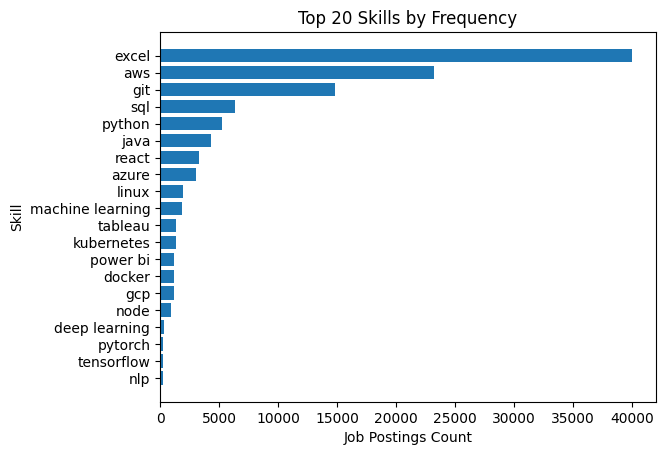

In [43]:
import matplotlib.pyplot as plt

plt.figure()
plt.barh(top_skills["skill"], top_skills["count"])
plt.xlabel("Job Postings Count")
plt.ylabel("Skill")
plt.title("Top 20 Skills by Frequency")
plt.gca().invert_yaxis()
plt.show()


### Skill Demand Percentage (Relative Market Share)

In [44]:
top_skills_pct = skill_freq_df.sort_values("percentage", ascending=False).head(top_n)

top_skills_pct


,skill,count,percentage
0,excel,40025,0.3551
3,aws,23233,0.2061
2,git,14815,0.1314
4,sql,6322,0.0561
8,python,5274,0.0468
5,java,4345,0.0386
1,react,3298,0.0293
10,azure,3087,0.0274
12,linux,1957,0.0174
13,machine learning,1897,0.0168


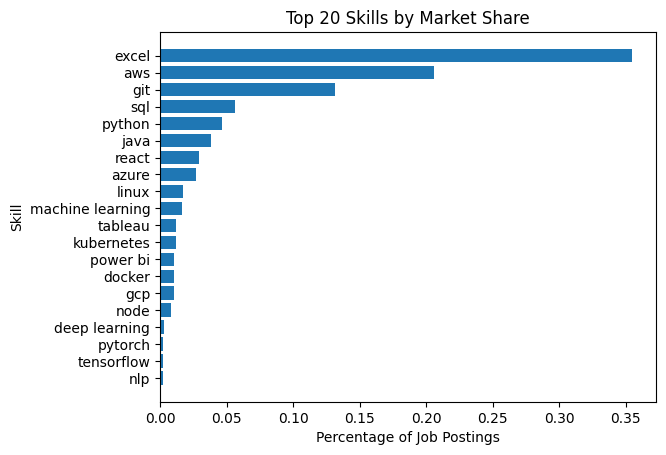

In [45]:
plt.figure()
plt.barh(top_skills_pct["skill"], top_skills_pct["percentage"])
plt.xlabel("Percentage of Job Postings")
plt.ylabel("Skill")
plt.title("Top 20 Skills by Market Share")
plt.gca().invert_yaxis()
plt.show()


In [46]:
skill_freq_sorted = skill_freq_df.sort_values("count", ascending=False)
skill_freq_sorted["cumulative_percentage"] = skill_freq_sorted["percentage"].cumsum()

skill_freq_sorted.head(30)


,skill,count,percentage,cumulative_percentage
0,excel,40025,0.3551,0.3551
3,aws,23233,0.2061,0.5612
2,git,14815,0.1314,0.6926
4,sql,6322,0.0561,0.7487
8,python,5274,0.0468,0.7955
5,java,4345,0.0386,0.8341
1,react,3298,0.0293,0.8634
10,azure,3087,0.0274,0.8908
12,linux,1957,0.0174,0.9082
13,machine learning,1897,0.0168,0.9250


### Long-Tail Distribution (Skill Inequality)

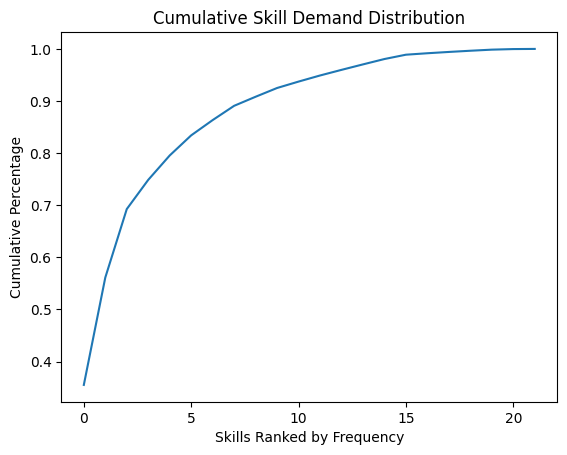

In [47]:
plt.figure()
plt.plot(skill_freq_sorted["cumulative_percentage"].values)
plt.xlabel("Skills Ranked by Frequency")
plt.ylabel("Cumulative Percentage")
plt.title("Cumulative Skill Demand Distribution")
plt.show()


## Salary vs Skills Count Analysis

In [48]:
combined_canonical["skills_count"] = combined_canonical["skills_norm"].apply(
    lambda x: len(x) if isinstance(x, list) else 0
)


In [49]:
combined_canonical["skills_count"].describe()


,skills_count
count,129334.000000
mean,0.871449
std,1.215776
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,14.000000


### Filter rows with usable salary

In [50]:
salary_df = combined_canonical[
    (combined_canonical["salary_final"].notna()) &
    (combined_canonical["salary_final"] > 0)
].copy()


### Salary vs Skills Count (scatter)

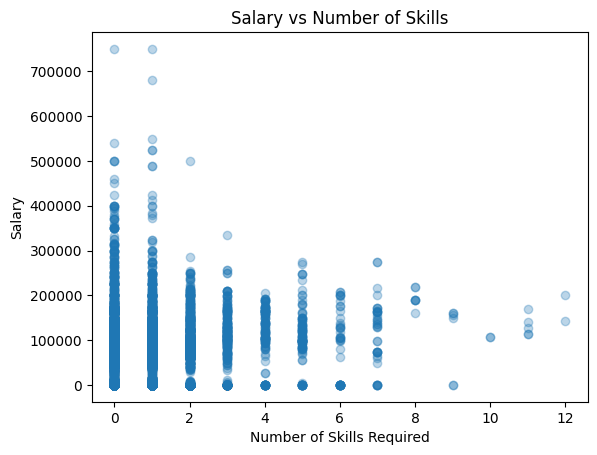

In [51]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(
    salary_df["skills_count"],
    salary_df["salary_final"],
    alpha=0.3
)
plt.xlabel("Number of Skills Required")
plt.ylabel("Salary")
plt.title("Salary vs Number of Skills")
plt.show()


### Bucket skills count

In [52]:
salary_df["skills_bucket"] = pd.cut(
    salary_df["skills_count"],
    bins=[0,1,3,5,8,15,50],
    right=True
)

bucket_salary = salary_df.groupby("skills_bucket")["salary_final"].mean()
bucket_salary


/tmp/ipython-input-3498895685.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bucket_salary = salary_df.groupby("skills_bucket")["salary_final"].mean()


,salary_final
skills_bucket,
"(0, 1]",51976.864979
"(1, 3]",73310.353351
"(3, 5]",110363.430405
"(5, 8]",107175.284946
"(8, 15]",123160.000000
"(15, 50]",NaN


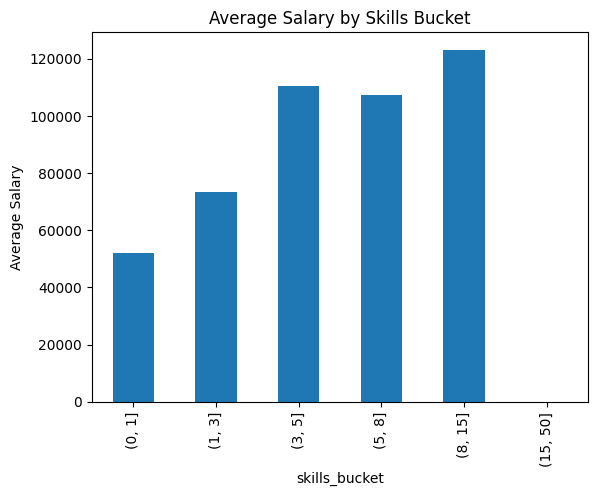

In [53]:
bucket_salary.plot(kind="bar")
plt.ylabel("Average Salary")
plt.title("Average Salary by Skills Bucket")
plt.show()


### Interpretation — Salary vs Number of Skills
#### **Do salaries increase with skill count?**

Yes, average salary increases as the number of required skills increases, particularly from the 0–1 skills bucket up to the 3–5 skills bucket. Roles requiring more skills generally command higher pay, indicating that skill breadth is valued in the job market.

#### **Where does it plateau?**

The salary growth begins to plateau after the 5–8 skills range. While roles requiring 8–15 skills still show higher average salaries, the increase is less steep compared to earlier buckets. This suggests diminishing returns beyond a certain skill threshold.

#### **Any outliers?**

Yes. The scatter plot shows high-salary outliers even at low skill counts (0–1 skills), likely representing:

- Senior or specialized roles

- Sales or commission-based jobs

- Executive or niche positions

Additionally, the 15–50 skills bucket has no valid salary data, indicating either very few jobs in this category or unreliable postings.

## Performing Final Sanity Checks

In [66]:
skill_freq_df.head(20)

,skill,count,percentage
2,git,14815,0.1314
4,sql,6322,0.0561
8,python,5274,0.0468
5,java,4345,0.0386
1,react,3298,0.0293
10,azure,3087,0.0274
12,linux,1957,0.0174
13,machine learning,1897,0.0168
6,tableau,1388,0.0123
16,kubernetes,1316,0.0117


In [ ]:
skill_freq_df.tail(20)

In [69]:
skill_freq_df["count"].describe()


,count
count,22.000000
mean,5123.090909
std,9530.486126
min,35.000000
25%,468.500000
50%,1352.000000
75%,4083.250000
max,40025.000000


#### The skill frequency distribution shows a long tail of specialized technologies (e.g., NLP, TensorFlow), indicating realistic job market diversity rather than noisy extraction artifacts.

In [70]:
salary_df["skills_text"] = salary_df["skills_norm"].apply(
    lambda x: " ".join(x) if isinstance(x, list) else ""
)


In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    vocabulary=skill_freq_df["skill"].tolist(),
    lowercase=False
)

X_tfidf = tfidf.fit_transform(salary_df["skills_text"])


In [72]:
X_tfidf.shape


(11758, 22)

In [73]:
tfidf.get_feature_names_out()


array(['excel', 'aws', 'git', 'sql', 'python', 'java', 'react', 'azure',
       'linux', 'machine learning', 'tableau', 'kubernetes', 'power bi',
       'docker', 'gcp', 'node', 'deep learning', 'pytorch', 'tensorflow',
       'nlp', 'django', 'fastapi'], dtype=object)

#### Non-zero weights only where skills exist in the array

In [76]:
X_tfidf[10:].toarray()


array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.56671149, 0.        , 0.82391631, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

#### Save the matrix

In [79]:
joblib.dump(X_tfidf, "skills_tfidf_matrix_v1.pkl")


['skills_tfidf_matrix_v1.pkl']

### This notebook produces canonical dataset v2 and NLP feature artifacts used for downstream clustering and salary modeling.